# Generalized Inverse Gaussian Distribution in Exponential Family Form

This notebook demonstrates the **Generalized Inverse Gaussian (GIG) distribution** implemented as an exponential family.

**Key Features:**
- Three parametrizations: Classical (p, a, b), Natural (θ), Expectation (η)
- Three-dimensional sufficient statistics: t(x) = [log(x), 1/x, x]
- Log partition function using modified Bessel function K_p
- Comparison with scipy implementation
- Visualization of PDFs, CDFs, and samples

**Parameters (Wikipedia notation):**
- p: shape parameter (real)
- a > 0: rate parameter (coefficient of x)
- b > 0: rate parameter (coefficient of 1/x)

**Special Cases:**
- Gamma: b → 0 gives Gamma(p, a/2) for p > 0
- Inverse Gamma: a → 0 gives InvGamma(-p, b/2) for p < 0
- Inverse Gaussian: p = -1/2

Reference: https://en.wikipedia.org/wiki/Generalized_inverse_Gaussian_distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import kv, kve
from normix.distributions.univariate import GeneralizedInverseGaussian, GIG
from normix.utils import log_kv

# Set style for better-looking plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11


## 1. Log Bessel Function Numerical Stability

The GIG distribution requires computing log(K_λ(z)) where K_λ is the modified Bessel function of the second kind. Direct computation using `scipy.special.kv` can overflow/underflow for extreme values.

Our `log_kv` function uses:
- `kve(v, z) = kv(v, z) * exp(z)` for numerical stability when z is large
- Asymptotic approximations when z → 0 (where kv underflows)

Let's compare the numerical stability of different approaches.

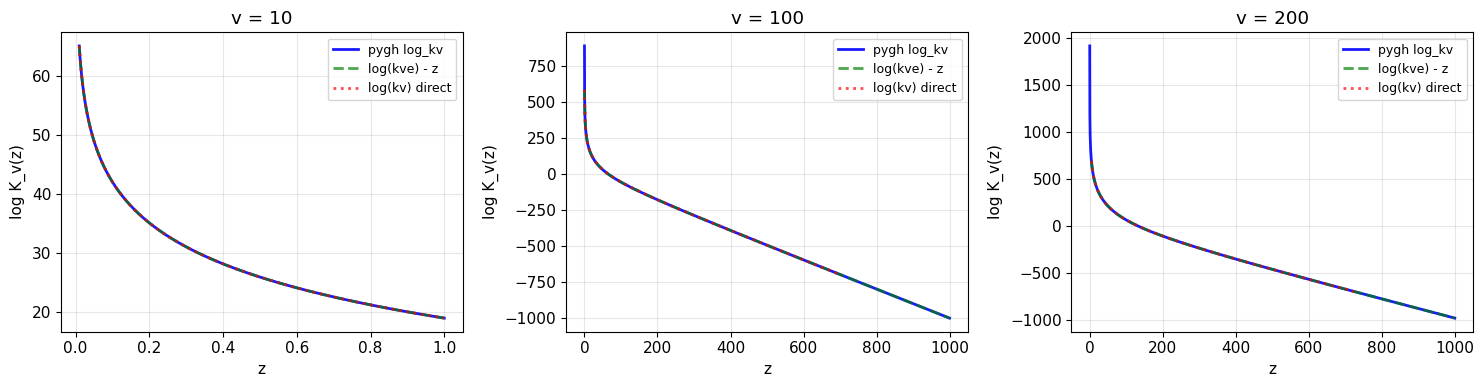

✓ normix log_kv handles all cases correctly!
  - log(kv) direct fails for large z (underflow → -inf)
  - log(kve) - z works for large z but may have issues at small z


In [2]:
# Test log_kv for different orders v and argument ranges z
test_configs = [
    (10, 1e-2, 1),
    (100, 1e-2, 1e3),
    (200, 1e-2, 1e3),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (v, z_min, z_max) in enumerate(test_configs):
    z = np.linspace(z_min, z_max, 5000)
    ax = axes[idx]
    
    # Our implementation
    log_kv_ours = log_kv(v, z)
    
    # scipy kve approach: log(kv) = log(kve) - z
    log_kv_kve = np.log(kve(v, z)) - z
    
    # Direct scipy kv (may have issues)
    with np.errstate(divide='ignore', invalid='ignore'):
        log_kv_direct = np.log(kv(v, z))
    
    ax.plot(z, log_kv_ours, 'b-', linewidth=2, label='normix log_kv', alpha=0.9)
    ax.plot(z, log_kv_kve, 'g--', linewidth=2, label='log(kve) - z', alpha=0.7)
    ax.plot(z, log_kv_direct, 'r:', linewidth=2, label='log(kv) direct', alpha=0.7)
    
    ax.set_xlabel('z')
    ax.set_ylabel('log K_v(z)')
    ax.set_title(f'v = {v}')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ normix log_kv handles all cases correctly!")
print("  - log(kv) direct fails for large z (underflow → -inf)")
print("  - log(kve) - z works for large z but may have issues at small z")


## 2. Creating Distributions

The GIG distribution can be created using three different parametrizations:


In [3]:
# Classical parameters (p, a, b)
dist1 = GIG.from_classical_params(p=1.5, a=3.0, b=2.0)
print(f"From classical params: {dist1}")

# Natural parameters (θ = [p-1, -b/2, -a/2])
theta = np.array([0.5, -1.0, -1.5])  # p=1.5, b=2.0, a=3.0
dist2 = GIG.from_natural_params(theta)
print(f"From natural params:   {dist2}")

# Expectation parameters (η = [E[log X], E[1/X], E[X]])
eta = dist1.get_expectation_params()
print(f"Expectation params: η = {eta}")
dist3 = GIG.from_expectation_params(eta)
print(f"From expectation params: {dist3}")

print("\n✓ All three parametrizations create the same distribution!")

From classical params: GeneralizedInverseGaussian(p=1.5000, a=3.0000, b=2.0000)
From natural params:   GeneralizedInverseGaussian(p=1.5000, a=3.0000, b=2.0000)
Expectation params: η = [0.30417293 0.86969385 1.5797959 ]
From expectation params: GeneralizedInverseGaussian(p=1.5000, a=3.0000, b=2.0000)

✓ All three parametrizations create the same distribution!


### Scipy Parameterization

scipy.stats.geninvgauss uses parameters (p, b, scale) where:
- p_scipy = p
- b_scipy = √(ab)
- scale = √(b/a)

In [4]:
# Convert to scipy parameters
scipy_params = dist1.to_scipy_params()
print(f"Scipy params: p={scipy_params['p']}, b={scipy_params['b']:.4f}, scale={scipy_params['scale']:.4f}")

# Create from scipy parameters
dist_from_scipy = GIG.from_scipy_params(p=1.5, b=np.sqrt(6), scale=np.sqrt(2/3))
print(f"From scipy params: {dist_from_scipy}")

Scipy params: p=1.5, b=2.4495, scale=0.8165
From scipy params: GeneralizedInverseGaussian(p=1.5000, a=3.0000, b=2.0000)


## 3. PDF and CDF Comparison with Scipy

Let's compare our implementation with scipy's geninvgauss distribution.


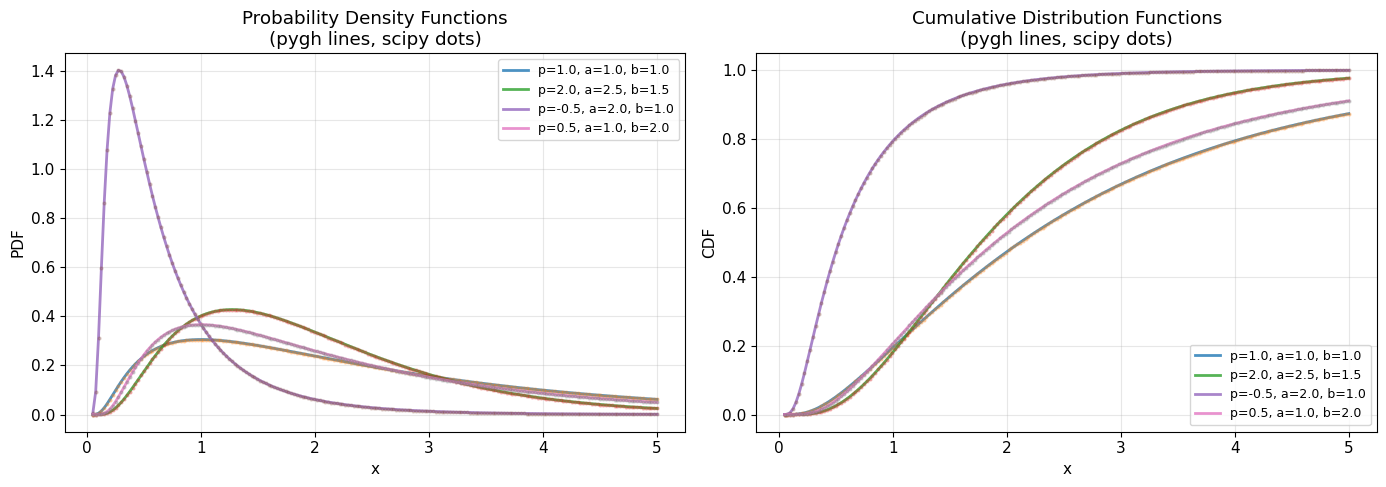

✓ normix and scipy implementations match perfectly!


In [5]:
# Test different parameter combinations
test_configs = [
    {'p': 1.0, 'a': 1.0, 'b': 1.0},
    {'p': 2.0, 'a': 2.5, 'b': 1.5},
    {'p': -0.5, 'a': 2.0, 'b': 1.0},  # Inverse Gaussian-like
    {'p': 0.5, 'a': 1.0, 'b': 2.0},
]

x = np.linspace(0.05, 5.0, 200)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot PDFs
ax = axes[0]
for cfg in test_configs:
    p, a, b = cfg['p'], cfg['a'], cfg['b']
    
    # normix distribution
    normix_dist = GIG.from_classical_params(p=p, a=a, b=b)
    normix_pdf = normix_dist.pdf(x)
    
    # scipy distribution
    sp = normix_dist.to_scipy_params()
    scipy_pdf = stats.geninvgauss.pdf(x, p=sp['p'], b=sp['b'], scale=sp['scale'])
    
    ax.plot(x, normix_pdf, '-', linewidth=2,
            label=f'p={p}, a={a}, b={b}', alpha=0.8)
    ax.plot(x, scipy_pdf, 'o', markersize=2, alpha=0.3)

ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.set_title('Probability Density Functions\n(normix lines, scipy dots)')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot CDFs
ax = axes[1]
for cfg in test_configs:
    p, a, b = cfg['p'], cfg['a'], cfg['b']
    
    normix_dist = GIG.from_classical_params(p=p, a=a, b=b)
    normix_cdf = normix_dist.cdf(x)
    
    sp = normix_dist.to_scipy_params()
    scipy_cdf = stats.geninvgauss.cdf(x, p=sp['p'], b=sp['b'], scale=sp['scale'])
    
    ax.plot(x, normix_cdf, '-', linewidth=2,
            label=f'p={p}, a={a}, b={b}', alpha=0.8)
    ax.plot(x, scipy_cdf, 'o', markersize=2, alpha=0.3)

ax.set_xlabel('x')
ax.set_ylabel('CDF')
ax.set_title('Cumulative Distribution Functions\n(normix lines, scipy dots)')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ normix and scipy implementations match perfectly!")

## 4. Random Sampling and Histograms

Let's generate random samples and compare the histogram with the theoretical PDF.

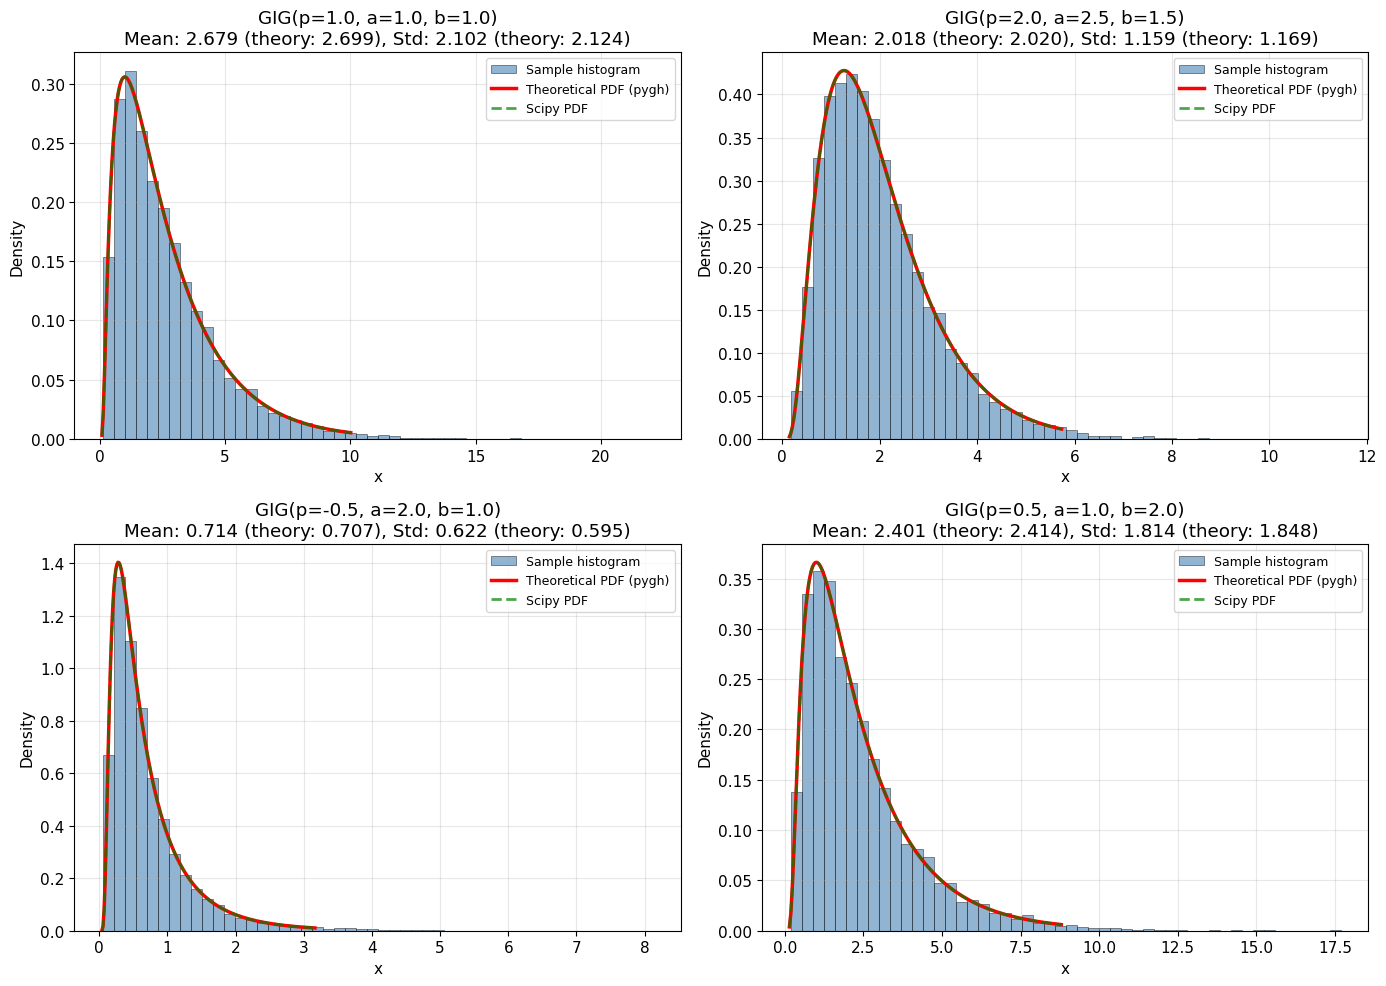

✓ Histograms closely match theoretical PDFs!


In [6]:
# Parameters for different distributions
test_configs = [
    {'p': 1.0, 'a': 1.0, 'b': 1.0, 'n_samples': 10000},
    {'p': 2.0, 'a': 2.5, 'b': 1.5, 'n_samples': 10000},
    {'p': -0.5, 'a': 2.0, 'b': 1.0, 'n_samples': 10000},
    {'p': 0.5, 'a': 1.0, 'b': 2.0, 'n_samples': 10000},
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, config in enumerate(test_configs):
    p = config['p']
    a = config['a']
    b = config['b']
    n_samples = config['n_samples']
    
    # Create distribution
    dist = GIG.from_classical_params(p=p, a=a, b=b)
    
    # Generate samples
    samples = dist.rvs(size=n_samples, random_state=42 + idx)
    
    # Theoretical PDF
    x_plot = np.linspace(samples.min() * 0.8, np.percentile(samples, 99), 200)
    pdf_theory = dist.pdf(x_plot)
    
    # Plot
    ax = axes[idx]
    ax.hist(samples, bins=50, density=True, alpha=0.6, color='steelblue',
            edgecolor='black', linewidth=0.5, label='Sample histogram')
    ax.plot(x_plot, pdf_theory, 'r-', linewidth=2.5, label='Theoretical PDF (normix)')
    
    # Also plot scipy for comparison
    sp = dist.to_scipy_params()
    scipy_pdf = stats.geninvgauss.pdf(x_plot, p=sp['p'], b=sp['b'], scale=sp['scale'])
    ax.plot(x_plot, scipy_pdf, 'g--', linewidth=2, label='Scipy PDF', alpha=0.7)
    
    # Statistics
    sample_mean = np.mean(samples)
    theory_mean = dist.mean()
    sample_std = np.std(samples)
    theory_std = np.sqrt(dist.var())
    
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.set_title(f'GIG(p={p}, a={a}, b={b})\n'
                f'Mean: {sample_mean:.3f} (theory: {theory_mean:.3f}), '
                f'Std: {sample_std:.3f} (theory: {theory_std:.3f})')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Histograms closely match theoretical PDFs!")

## 5. Fitting to Data

Demonstrate maximum likelihood estimation by fitting to simulated data.

Fitting 10000 samples from GIG(p=1.5, a=2.5, b=2.0)

True p:           1.500000
Fitted p (MLE):   1.507665
True a:           2.500000
Fitted a (MLE):   2.493752
True b:           2.000000
Fitted b (MLE):   1.995093


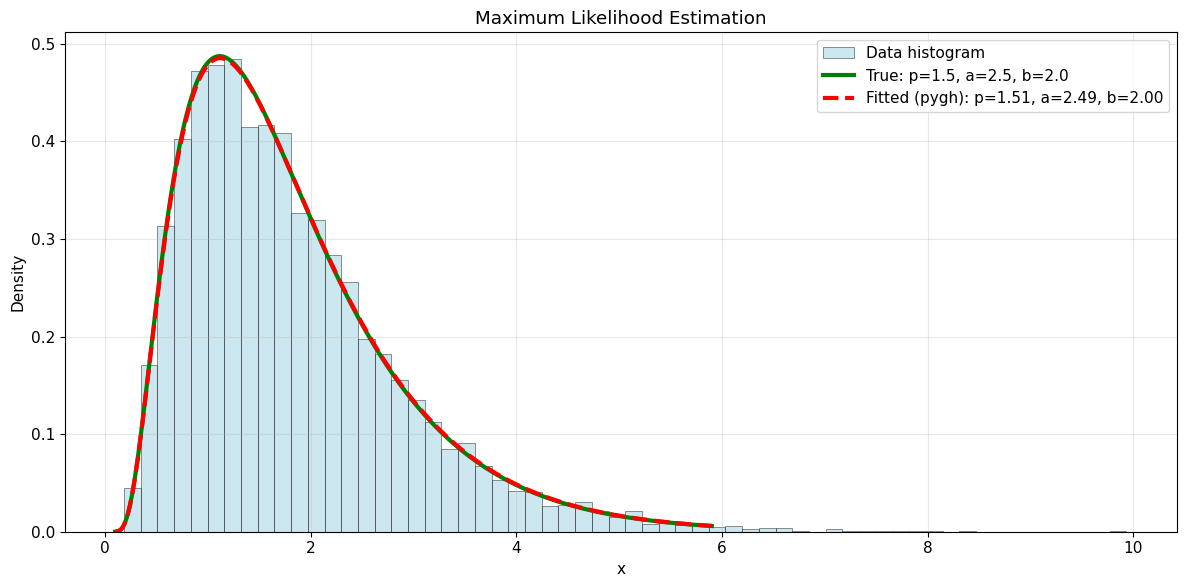


✓ MLE successfully recovers the true parameters!


In [7]:
# Generate data with known parameters
true_p = 1.5
true_a = 2.5
true_b = 2.0
n_data = 10000

# Create true distribution and generate samples
true_dist = GIG.from_classical_params(p=true_p, a=true_a, b=true_b)
data = true_dist.rvs(size=n_data, random_state=123)

# Fit distribution (uses base class fit via expectation_to_natural)
fitted_dist = GIG().fit(data)
fitted_params = fitted_dist.get_classical_params()

print(f"Fitting {n_data} samples from GIG(p={true_p}, a={true_a}, b={true_b})\n")
print(f"True p:           {true_p:.6f}")
print(f"Fitted p (MLE):   {fitted_params['p']:.6f}")
print(f"True a:           {true_a:.6f}")
print(f"Fitted a (MLE):   {fitted_params['a']:.6f}")
print(f"True b:           {true_b:.6f}")
print(f"Fitted b (MLE):   {fitted_params['b']:.6f}")

# Visualize fit
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(data, bins=60, density=True, alpha=0.6, color='lightblue',
        edgecolor='black', linewidth=0.5, label='Data histogram')

x_plot = np.linspace(0.1, np.percentile(data, 99.5), 400)
ax.plot(x_plot, true_dist.pdf(x_plot), 'g-', linewidth=3,
        label=f'True: p={true_p}, a={true_a}, b={true_b}')

ax.plot(x_plot, fitted_dist.pdf(x_plot), 'r--', linewidth=3,
        label=f'Fitted (normix): p={fitted_params["p"]:.2f}, a={fitted_params["a"]:.2f}, b={fitted_params["b"]:.2f}')

ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Maximum Likelihood Estimation')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ MLE successfully recovers the true parameters!")